In [1]:
library(tidyverse)
library(broom)
library(janitor)
library(ggforce)
library(arcadiathemeR)

── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test




## Calculate Kozak sequence scores for all transcripts in the human transcriptome and all sORFs predicted by peptigate

The Kozak consensus sequence functions as a translation initiation start site and enhances the efficiency of translation by directing ribosomes to the correct start codon [https://doi.org/10.1093/nar/15.20.8125].
It occurs six basepairs upstream and one basepair downstream of the start codon in a transcript [https://doi.org/10.1093/nar/15.20.8125].
The exact sequence varies so each Kozak sequence can be scored in comparison to the most common sequence motif [https://doi.org/10.1186/s13059-017-1222-2].
We scored each Kozak sequence as performed in [https://doi.org/10.1186/s13059-017-1222-2]: using the sequence motif Gcc[A/G]cc**AUG**G, we designated upper-case letters as highly conserved (scored +3) and lower-case letters as common (scored +1).
By this scoring, if the first letter in the Kozak sequence is G, it would be scored +3; if the second letter is C, it would be scored +1, and so on.
The fourth position would be scored +3 if it is an A or a G.
We did not score the start codon (bolded letters).
The maximum score is 13.

First calculate the Kozak sequence scores for the full human transcriptome.

In [2]:
command <- paste(
    "python ../../scripts/calculate_all_kozak_scores.py",
    "--transcript ../../peptigate/running_peptigate/GCF_000001405.40_GRCh38.p14_rna.fna",
    "--orf ../../peptigate/running_peptigate/GCF_000001405.40_GRCh38.p14_rna.fna.transdecoder.cds",
    "--output GCF_000001405.40_GRCh38.p14_rna_kozak_scores.tsv",
    "--tool transdecoder",
    sep = " \\\n"
)
system(command, intern = TRUE)

[1] "Results written to GCF_000001405.40_GRCh38.p14_rna_kozak_scores.tsv"

Next, calculate the Kozak sequences scores for the sORFs.
We'll have to go back to the transcriptome and extract the sORF transcripts; plm-utils only outputs the sORF sequences, not the full transcripts.

In [3]:
command <- paste(
  "seqkit grep",
  "--pattern-file ../../peptigate/results/sORF/plmutils/plmutils_peptide_names.faa.gz",
  "-o sorf_transcripts.fa",
  "../../peptigate/running_peptigate/GCF_000001405.40_GRCh38.p14_rna.fna",
  sep = " \\\n"
)

system(command, intern = TRUE)

character(0)

In [4]:
system("gunzip ../../peptigate/results/predictions/peptides.ffn.gz")

In [5]:
command <- paste(
    "python ../../scripts/calculate_all_kozak_scores.py",
    "--transcript sorf_transcripts.fa",
    "--orf ../../peptigate/results/predictions/peptides.ffn",
    "--output sorf_kozak_scores.tsv",
    "--tool orfipy",
    sep = " \\\n"
)
system(command, intern = TRUE)

[1] "Results written to sorf_kozak_scores.tsv"

## Analyze the Kozak sequence scores

We label the Kozak sequences by RefSeq Gene labels.
Curated genes start with "N" and predicted genes start with "X".
Coding genes are specified with "M" and noncoding with "R" ([source](https://hgdownload.soe.ucsc.edu/gbdb/mm10/trackDb.txt)).
* NM: curated coding
* NR: curated noncoding
* XM: predicted coding
* XR: predicted noncoding

In [6]:
sorf_kozak <- read_tsv("sorf_kozak_scores.tsv", show_col_types = FALSE) %>%
  clean_names() %>%
  filter(!is.na(kozak_score)) %>%
  mutate(origin = "sORF") %>%
  mutate(transcript_type = gsub("_.*", "", name),
         transcript_type_description = ifelse(transcript_type == "NM", "Coding",
                                              ifelse(transcript_type == "NR", "Noncoding", 
                                                     ifelse(transcript_type == "XM", "Predicted coding", "Predicted noncoding"))))

In [7]:
all_kozak <- read_tsv("GCF_000001405.40_GRCh38.p14_rna_kozak_scores.tsv", show_col_types = FALSE) %>%
  clean_names() %>%
  filter(type == "complete") %>%
  filter(!is.na(kozak_score)) %>%
  mutate(origin = "All") %>%
  mutate(transcript_type = gsub("_.*", "", name),
         transcript_type_description = ifelse(transcript_type == "NM", "Coding",
                                              ifelse(transcript_type == "NR", "Noncoding", 
                                                     ifelse(transcript_type == "XM", "Predicted coding", "Predicted noncoding"))))

In [8]:
kozak <- bind_rows(sorf_kozak, all_kozak)

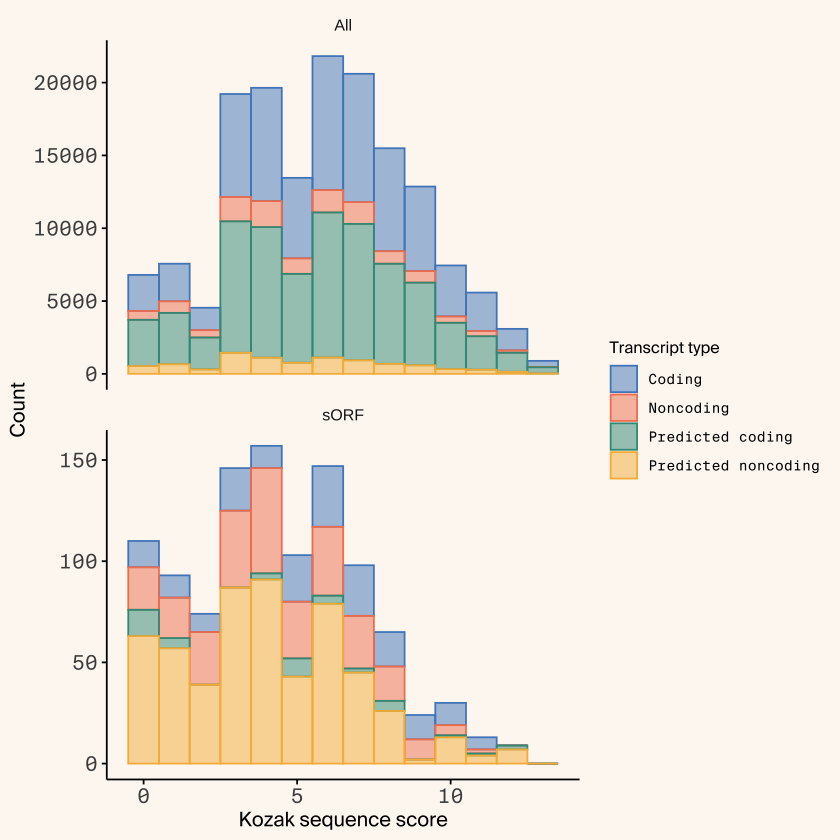

In [9]:
ggplot(kozak, aes(x = kozak_score, fill = transcript_type_description, color = transcript_type_description)) +
  geom_histogram(alpha = .5, bins = 14) +
  facet_wrap(~origin, nrow = 2, scales = "free_y") +
  theme_arcadia() +
  labs(x = "Kozak sequence score", y = "Count", fill = "Transcript type", color = "Transcript type") +
  scale_fill_arcadia() +
  scale_color_arcadia()

In [10]:
results <- kozak %>%
  group_by(transcript_type_description) %>%
  group_map(~ tidy(t.test(kozak_score ~ origin, data = .x)), .keep = TRUE) %>%
  bind_rows()
results

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.6188908,6.047462,5.428571,2.904830,4.112521e-03,189.07932,0.1986191,1.039162,Welch Two Sample t-test,two.sided
0.8856087,5.251200,4.365591,5.699887,2.908772e-08,294.65239,0.5798272,1.191390,Welch Two Sample t-test,two.sided
1.5922068,5.703318,4.111111,2.920064,5.498573e-03,44.03526,0.4933235,2.691090,Welch Two Sample t-test,two.sided
1.1511919,5.194357,4.043165,9.620795,1.465450e-20,642.68740,0.9162267,1.386157,Welch Two Sample t-test,two.sided


In [11]:
t_test_result <- t.test(kozak_score ~ origin, data = kozak)

tidy(t_test_result)

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1.40786,5.782977,4.375117,16.35812,6.358065e-54,1083.866,1.238987,1.576732,Welch Two Sample t-test,two.sided


In [12]:
kozak %>%
  group_by(transcript_type_description, kozak_score) %>%
  tally() %>%
  arrange(desc(kozak_score))

transcript_type_description,kozak_score,n
<chr>,<dbl>,<int>
Coding,13,415
Noncoding,13,23
Predicted coding,13,425
Predicted noncoding,13,28
Coding,12,1477
Noncoding,12,159
Predicted coding,12,1310
Predicted noncoding,12,151
Coding,11,2648


In [13]:
kozak %>% group_by(origin, transcript_type_description) %>% 
  summarize(mean_ks = mean(kozak_score),
            sd_ks = sd(kozak_score),
            median_ks = median(kozak_score)) %>%
  arrange(transcript_type_description)

`summarise()` has grouped output by 'origin'. You can override using the `.groups` argument.


origin,transcript_type_description,mean_ks,sd_ks,median_ks
<chr>,<chr>,<dbl>,<dbl>,<dbl>
All,Coding,6.047462,2.923698,6
sORF,Coding,5.428571,2.924844,6
All,Noncoding,5.251200,2.892160,5
sORF,Noncoding,4.365591,2.557757,4
All,Predicted coding,5.703318,2.929574,6
sORF,Predicted coding,4.111111,3.657012,5
All,Predicted noncoding,5.194357,3.010908,5
sORF,Predicted noncoding,4.043165,2.719620,4


# Exploratory analyses

The results below are not included in the peptigate pub.

## Compare within sORFs

Within sORFs, some are demarcated as coding transcripts in the reference transcriptome.
Compare mean values within just sORFs.

In [14]:
tmp1 <- sorf_kozak %>%
  filter(transcript_type_description %in% c("Coding", "Noncoding"))
t.test(kozak_score ~ transcript_type_description, data = tmp1)


	Welch Two Sample t-test

data:  kozak_score by transcript_type_description
t = 4.0552, df = 366.69, p-value = 6.122e-05
alternative hypothesis: true difference in means between group Coding and group Noncoding is not equal to 0
95 percent confidence interval:
 0.5475158 1.5784443
sample estimates:
   mean in group Coding mean in group Noncoding 
               5.428571                4.365591 


In [15]:
tmp2 <- sorf_kozak %>%
  filter(transcript_type_description %in% c("Coding", "Predicted coding"))
t.test(kozak_score ~ transcript_type_description, data = tmp2)


	Welch Two Sample t-test

data:  kozak_score by transcript_type_description
t = 2.2513, df = 58.108, p-value = 0.02816
alternative hypothesis: true difference in means between group Coding and group Predicted coding is not equal to 0
95 percent confidence interval:
 0.1461046 2.4888160
sample estimates:
          mean in group Coding mean in group Predicted coding 
                      5.428571                       4.111111 


In [16]:
tmp3 <- sorf_kozak %>%
  filter(transcript_type_description %in% c("Coding", "Predicted noncoding"))
t.test(kozak_score ~ transcript_type_description, data = tmp3)


	Welch Two Sample t-test

data:  kozak_score by transcript_type_description
t = 5.7247, df = 305.8, p-value = 2.473e-08
alternative hypothesis: true difference in means between group Coding and group Predicted noncoding is not equal to 0
95 percent confidence interval:
 0.9092028 1.8616091
sample estimates:
             mean in group Coding mean in group Predicted noncoding 
                         5.428571                          4.043165 


## Does the kozak score correlate with plm-utils score?

Plm-utils scores transcripts from 0-1.
By default, transcripts that score over 0.5 are considered coding.
Below we test whether the plm-utils score is correlated with the strength of the Kozak sequence.

In [17]:
plmutils_scores <- read_tsv("../../peptigate/results/predictions/peptide_predictions.tsv.gz", show_col_types = FALSE)

In [18]:
sorf_plm_kozak <- inner_join(plmutils_scores, sorf_kozak, by = c("peptide_id" = "name")) %>%
  select(peptide_id, plmutils_class_probability, kozak_score, transcript_type, transcript_type_description)

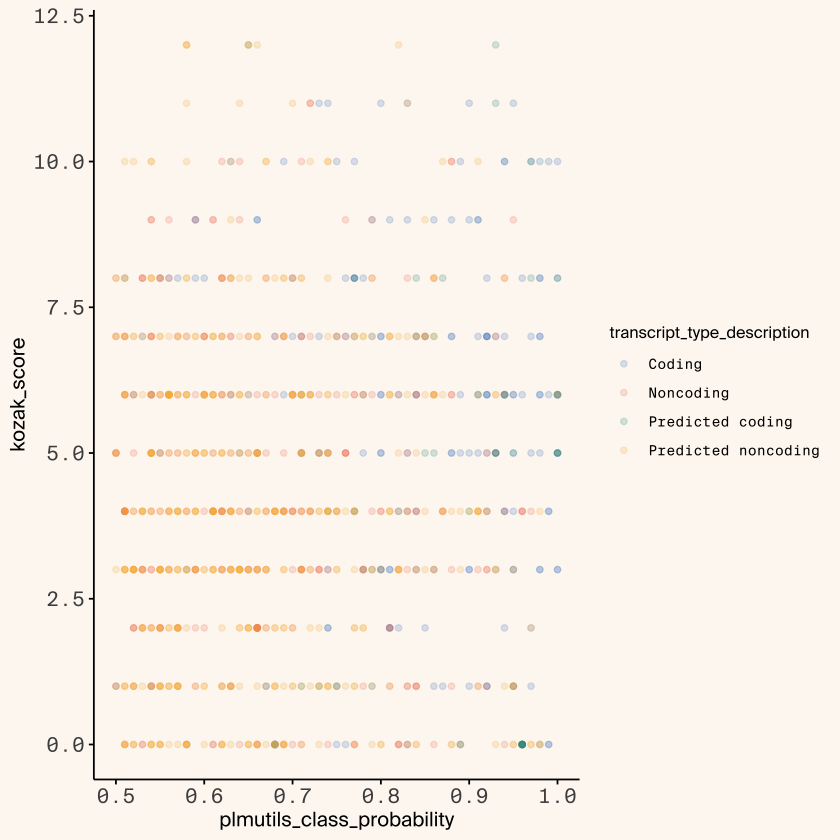

In [19]:
ggplot(sorf_plm_kozak, aes(x = plmutils_class_probability, y = kozak_score, color = transcript_type_description)) +
  geom_point(alpha = 0.2) +
  theme_arcadia() +
  scale_color_arcadia() 

In [20]:
# Linear regression model
model <- lm(kozak_score ~ plmutils_class_probability, data = sorf_plm_kozak)

# Summarize the model to view results
summary(model)


Call:
lm(formula = kozak_score ~ plmutils_class_probability, data = sorf_plm_kozak)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.6676 -2.2067 -0.2784  1.7728  7.7523 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  3.6537     0.4335   8.428   <2e-16 ***
plmutils_class_probability   1.0242     0.6033   1.698   0.0899 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.801 on 1067 degrees of freedom
Multiple R-squared:  0.002694,	Adjusted R-squared:  0.001759 
F-statistic: 2.882 on 1 and 1067 DF,  p-value: 0.08988


In [21]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/taylorreiter/miniconda3/envs/pepeval/lib/libopenblasp-r0.3.26.dylib;  LAPACK version 3.12.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/New_York
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] arcadiathemeR_0.1.0 ggforce_0.4.2       janitor_2.2.0      
 [4] broom_1.0.5         lubridate_1.9.3     forcats_1.0.0      
 [7] stringr_1.5.1       dplyr_1.1.4         purrr_1.0.2        
[10] readr_2.1.5         tidyr_1.3.1         tibble_3.2.1       
[13] ggplot2_3.5.0       tidyverse_2.0.0    

loaded via a namespace (and not attached):
 [1] utf8_1.2.4       generics_0.1.3   stringi_1.8.3    hms_1.1.3       
 [5] digest_0.6.35    magrittr_2.0.3   evaluate_0.23    grid_4.3.3      
 